In [1]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAETest import SeqVAETest
import pandas as pd
import torch
import numpy as np

pd.set_option("display.max_rows", None)

In [2]:
extants_aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/SPG1_STRSG_full_b0.1_filt_encoded_weighted.pkl")



In [75]:
extants_aln.head()

,id,sequence,encoding,weights
0,SPG1_STRSG/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066667
1,UniRef100_Q93EM8/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000
2,UniRef100_Q53975/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000
3,UniRef100_A0A509DAN6/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066667
4,UniRef100_A0A448DI38/1-351,MEKEKKMKYFLRKSAFGLASVSAAFLVGTTLDTTMTVSAEPAGIIA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000


In [3]:
extants_aln.shape, extants_aln.columns


((3084, 4), Index(['id', 'sequence', 'encoding', 'weights'], dtype='object'))

In [4]:
train_dataset = MSA_Dataset(extants_aln["encoding"], extants_aln["weights"], extants_aln["id"])
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False
)

SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


In [5]:
input_dims

9408

In [6]:
config={
            # Dataset info
            "alignment": "tets",
            "seq_theta": 0.2,  # reweighting
            "AA_count": 21,  # standard AA + gap
            "test_split": 0.2,
            "max_mutation": 4,  # how many mutations the model will test up to
            # ADAM
            "learning_rate": 1e-2,  # ADAM
            "weight_decay": 1e-4,  # ADAM
            # Hidden units
            "momentum": None,
            "dropout": None,
            # Training loop
            "epochs": 500,
            "batch_size": 128,
            "max_norm": 10,  # gradient clipping
            "patience": 3,
            # Model info - default settings
            "architecture": f"SeqVAE_0.25_ancestors_R",
            "latent_dims": 10,
            "hidden_dims": [256, 128, 64],
            # DMS data
            "dms_file": "../data/GFP_AEQVI_Sarkisyan_2016_dms_encoded.pkl",
            "dms_metadata": "../data/DMS_substitutions.csv",
            "dms_id": "GFP_AEQVI_Sarkisyan_2016",
}

model = SeqVAETest(input_dims, 10, hidden_dims=config["hidden_dims"], config=config)

In [18]:

model = torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/gb1_model_an_ex.pt")
model.eval()

SeqVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=9408, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (z_mu_sampler): Linear(in_features=64, out_features=10, bias=True)
  (z_logvar_sampler): Linear(in_features=64, out_features=10, bias=True)
  (upscale_z): Linear(in_features=10, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Sequen

In [112]:
names = []
z_vals = []

for encoding, weights, name in train_loader:
    log_p, z_sample, z_mu, z_logvar = model.forward(encoding.float())
    names.append(name[0])
    z_vals.append(z_sample.detach().numpy())

df = pd.DataFrame({"id": names, "z": z_vals})
df.head()

,id,z
0,SPG1_STRSG/1-448,"[[1.5235792, -1.4414622, -0.354339, -0.4255955..."
1,UniRef100_Q93EM8/1-351,"[[-1.1665726, -0.26854217, -0.923925, 0.422906..."
2,UniRef100_Q53975/1-351,"[[0.14427263, -1.5015893, 1.3979671, -0.898246..."
3,UniRef100_A0A509DAN6/1-448,"[[1.4359875, 0.5196061, 0.083655514, 0.5734378..."
4,UniRef100_A0A448DI38/1-351,"[[-0.52230686, 0.39237663, -0.51865315, 0.6531..."


In [150]:
import torch.nn.functional as F
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt

total = 0
count = 0
for id, z in zip(df['id'], df['z']):
    x_hat = model.decode(torch.tensor(z))
    x_hat.shape
    orig_shape = tuple(x_hat.shape[0:-1])
    
    x_hat = torch.unsqueeze(x_hat, -1)
    x_hat = x_hat.view(orig_shape + (-1, 21))

    SEQ_POSITIONS = 0
    indices = x_hat.max(dim=-1).indices.tolist()
    
    test = extants_aln[extants_aln['id'] == id]['sequence'].values[0]
    recon = "".join([st.GAPPY_PROTEIN_ALPHABET[x] for x in indices[SEQ_POSITIONS]])

    total += mt.hamming_distance(test, recon)
    count += 1

print(total/count)


424.3599221789883


In [201]:
from sklearn.decomposition import PCA

test = [x.tolist()[0] for x in df['z']]
test = np.array(test)
test.shape

(3084, 10)

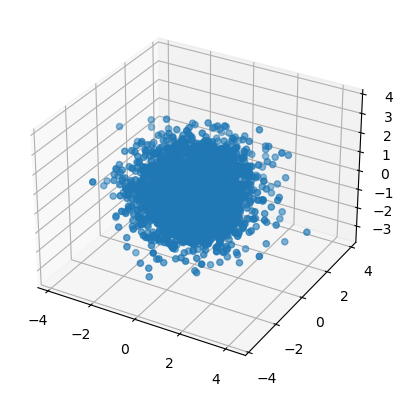

In [214]:
#df['z'].to_numpy()
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
transformed = pca.fit_transform(test)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2])
plt.show()

In [215]:
transformed.shape

(3084, 3)

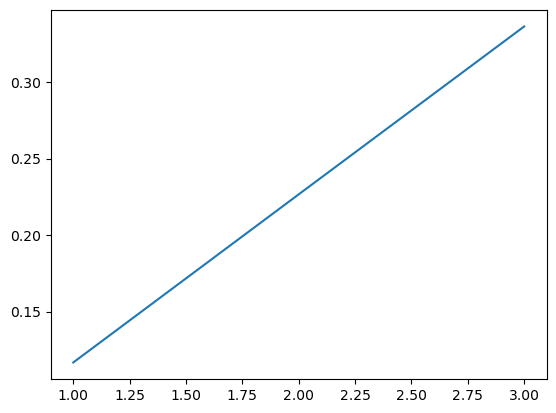

In [217]:
count = 0
data = []
for x in pca.explained_variance_ratio_:
    count += x
    data.append(count)

x = range(1,4,1)
plt.plot(x, data)

In [218]:
from sklearn.preprocessing import MinMaxScaler

# RGB scale 
scaler = MinMaxScaler((0,255))
new_data = scaler.fit_transform(transformed)
new_data

array([[132.86966313,  79.30969063,  86.67240984],
       [ 95.25845439,  97.68850655, 189.65175039],
       [ 46.83659587,  91.6456268 , 109.91812038],
       ...,
       [ 81.96824137, 136.06125173,  90.20950873],
       [108.82702352, 143.44337042, 130.74153751],
       [157.09939421, 106.23121327, 152.90265123]])

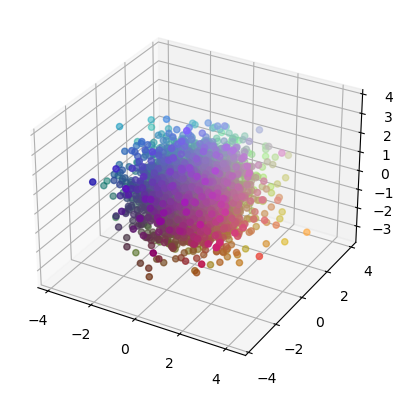

In [221]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])

ax.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], c=new_data/255)
plt.show()

In [237]:
pand = new_data.tolist()

In [282]:
df['colour'] = pand
df.loc[df['id'] == 'UniRef100_L7ZC84/5-536']

,id,z,colour


In [302]:
from ete3 import Tree, NodeStyle, TreeStyle

#tree = Tree("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/ancestors/trees/anc_tree_1_ancestors.nwk", 1)
#tree = Tree("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/ancestors/trees/prune_tree_1")
tree = Tree("(SPG1_STRSG/1-448:1,(UniRef100_Q93EM8/1-351:1,(UniRef100_Q53975/1-351:1,UniRef100_A0A509DAN6/1-448:1):0.5):0.5);")
print(tree)


ts = TreeStyle()

for idx, n in enumerate(tree.traverse()):
    if not n.is_leaf():
        continue
    

    nstyle = NodeStyle()
    nstyle["fgcolor"] = rgb_to_hex(df[df['id'] == n.name]['colour'].iloc[0])
    #nstyle['bgcolor'] = rgb_to_hex(df[df['id'] == n.name]['colour'].iloc[0])
    nstyle['size'] = 15
    n.set_style(nstyle)


circular_style = TreeStyle()
circular_style.mode = "c" # draw tree in circular mode
circular_style.scale = 40
tree.render("mytree.png", tree_style=circular_style)



   /-SPG1_STRSG/1-448
--|
  |   /-UniRef100_Q93EM8/1-351
   \-|
     |   /-UniRef100_Q53975/1-351
      \-|
         \-UniRef100_A0A509DAN6/1-448


{'nodes': [[247.47323146683553,
   248.6450312544785,
   252.18869841074013,
   253.3604981983831,
   0,
   None],
  [292.3868167468769,
   241.5327147806272,
   308.3868167468769,
   257.5327147806272,
   1,
   None],
  [224.02249893561975,
   256.5977093224443,
   229.26512816938722,
   261.8403385562118,
   2,
   None],
  [241.82031885910308,
   315.39393631823697,
   257.88997949919076,
   331.4635969583246,
   3,
   None],
  [212.46891388961996,
   213.20778700327688,
   218.12543158456958,
   218.86430469822653,
   4,
   None],
  [144.5473726817299,
   242.308978786032,
   160.6863880187306,
   258.44799412303274,
   5,
   None],
  [240.16004601248687,
   144.51746189735815,
   256.3681087828125,
   160.72552466768377,
   6,
   None]],
 'faces': [[307.8868167468769,
   243.5327147806272,
   402.8868167468769,
   255.5327147806272,
   1,
   'SPG1_STRSG/1-448'],
  [243.88793111445807,
   330.9025153879778,
   256.4157773065612,
   451.9537232666037,
   3,
   'UniRef100_Q93EM8/1-351

In [272]:
def rgb_to_hex(rgb):
    """Return color as #rrggbb for the given color values."""
    rounded_rgb = tuple(int(round(x)) for x in rgb)
    return '#%02X%02X%02X' % rounded_rgb

In [273]:
rgb_to_hex((255, 255, 255))

'#FFFFFF'